In [8]:
%matplotlib inline
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import json
import h5py
import numpy as np

from sklearn.metrics import classification_report,confusion_matrix

from IPython.display import display,Image,clear_output

In [36]:
import keras 
from keras.models import Sequential,Model,load_model,model_from_json
from keras.layers import Dense,Flatten,Dropout,Activation
from keras.layers import Conv2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras import losses,optimizers
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras.callbacks import History,ModelCheckpoint,TensorBoard
from keras.regularizers import l1,l2
from keras.utils.np_utils import to_categorical

In [30]:
location = './'
train_data_dir = '../imgs/train'
val_data_dir = '../imgs/val'

top_model_wts_path = location+'top_model_wts.h5'
ft_model_path = location+'ft_model.h5'

img_h = 256
img_w = 256

train_samples = [len(os.listdir(os.path.join(train_data_dir,i))) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
val_samples = [len(os.listdir(os.path.join(val_data_dir,i))) for i in sorted(os.listdir(val_data_dir))]
nb_val_samples = sum(val_samples)

nb_epochs = 50

In [11]:
sorted(os.listdir(train_data_dir))

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [12]:
train_samples

[2241, 2041, 2086, 2112, 2094, 2081, 2093, 1802, 1720, 1917]

In [13]:
val_samples

[248, 226, 231, 234, 232, 231, 232, 200, 191, 212]

In [14]:
nb_train_samples,nb_val_samples

(20187, 2237)

In [15]:
import keras.backend as K
if K.image_data_format() == 'channels_last':
    input_shape = (img_h,img_w,3)
else:
    input_shape = (3,img_h,img_w)
K.image_data_format()

'channels_last'

In [16]:
input_shape

(256, 256, 3)

In [17]:
base_model = VGG16(include_top=False,weights='imagenet',input_shape=input_shape)
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [18]:
for layer in base_model.layers:
    layer.trainable = False

In [19]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [20]:
def preprocess_input_vgg(x):
    x = np.expand_dims(x,axis=0)
    x = preprocess_input(x)
    return x[0]

In [21]:
def save_bottleneck_features(location):
    bottleneck_features_train_loc = location+'bottleneck_train_features.npy'
    bottleneck_features_test_loc = location+'bottleneck_test_features.npy'
    
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
    
    if not os.path.exists(bottleneck_features_train_loc):
        train_generator = datagen.flow_from_directory(train_data_dir,
                                                    target_size=(256,256),
                                                    batch_size=32,
                                                    class_mode=None,
                                                    shuffle=False
                                                    )
        bottleneck_features_train = base_model.predict_generator(train_generator,
                                                                 steps=nb_train_samples/32,
                                                                 verbose=1)
        np.save(open(bottleneck_features_train_loc,'wb'),bottleneck_features_train)
        
    if not os.path.exists(bottleneck_features_test_loc):
        test_generator = datagen.flow_from_directory(test_data_dir,
                                                     target_size=(256,256),
                                                     batch_size=16,
                                                     class_mode=None,
                                                     shuffle=False)
        bottleneck_features_test = base_model.predict_generator(test_generator,
                                                                steps=nb_val_samples/16,
                                                                verbose=1)
        np.save(open(bottleneck_features_test_loc,'wb'),bottleneck_features_test)

In [22]:
train_labels = []
for i in range(len(train_samples)):
    train_labels += [i]*train_samples[i]
train_labels = np.array(train_labels)
train_labels

array([0, 0, 0, ..., 9, 9, 9])

In [23]:
def train_categorical_model(location):
    bottleneck_features_train_loc = location+'bottleneck_train_features.npy'
    bottleneck_features_test_loc = location+'bottleneck_test_features.npy'
    
    bottleneck_features_train = np.load(open(bottleneck_features_train_loc,'rb'))
    train_labels = []
    for i in range(len(train_samples)):
        train_labels += [i]*train_samples[i]
    train_labels = np.array(train_labels)
    train_labels = to_categorical(train_labels)
    
    bottleneck_features_test = np.load(open(bottleneck_features_test_loc,'rb'))
    test_labels = []
    for i in range(len(val_samples)):
        test_labels += [i]*val_samples[i]
    test_labels = np.array(test_labels)
    test_labels = to_categorical(test_labels)
    
    top_model = Sequential()
    top_model.add(Dense(units=256,activation='relu',use_bias=True,kernel_regularizer=l1(l=0.01)))             # (512,8,8)
    top_model.add(Dropout(0.1))
    top_model.add(Dense(units=256,activation='relu',use_bias=True,kernel_regularizer=l2(l=0.01)))
    top_model.add(Dropout(0.1))
    top_model.add(Dense(units=10,activation='softmax',use_bias=True))
    
    top_model.compile(optimizer=optimizers.SGD(lr=0.0001,momentum=0.9),
                      loss=losses.categorical_crossentropy,
                      metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_wts_path,
                                 monitor='val_acc',
                                 verbsoe=1,
                                 save_best_only=True,
                                 save_weights_only=True,mode='auto')
    
    fit = top_model.fit(x=bottleneck_features_train,
                        y=train_labels,
                        batch_size=32,
                        epochs=nb_epochs,
                        callbacks=[checkpoint],
                        validation_data=(bottleneck_features_test,test_labels)
                       )
    with open(location+'best_model_history.json','w') as f:
        json.dump(fit.history,f)
    
    return top_model,fit.history

In [24]:
train_labels = []
for i in range(len(train_samples)):
    train_labels += [i]*train_samples[i]
train_labels = np.array(train_labels)
train_labels = to_categorical(train_labels)
train_labels

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [25]:
def finetune_categorical_model(location):
    for i in range(len(train_samples)):
        train_labels += [i]*train_samples[i]
    train_labels = np.array(train_labels)
    train_labels = to_categorical(train_labels)
    
    bottleneck_features_test = np.load(open(bottleneck_features_test_loc,'rb'))
    test_labels = []
    for i in range(len(val_samples)):
        test_labels += [i]*val_samples[i]
    test_labels = np.array(test_labels)
    test_labels = to_categorical(test_labels)
    
    top_model = Sequential()
    top_model.add(Dense(units=256,activation='relu',use_bias=True,kernel_regularizer=l1(l=0.01)))             # (512,8,8)
    top_model.add(Dropout(0.1))
    top_model.add(Dense(units=256,activation='relu',use_bias=True,kernel_regularizer=l2(l=0.01)))
    top_model.add(Dropout(0.1))
    top_model.add(Dense(units=10,activation='softmax',use_bias=True))
    
    top_model.load_weights(top_model_wts_path)
    
    model = Model(inputs=base_model.input,outputs=top_model(base_model.output))
    
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
    train_generator =  train_datagen.flow_from_directory(train_data_dir,
                                                         target_size=(256,256),
                                                         class_mode='categorical',
                                                         batch_size=32,
                                                         shuffle=True)
    
    
    test_datgen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
    test_generator = test_datgen.flow_from_directory(val_data_dir,
                                                     target_size=(256,256),
                                                     class_mode='categorical',
                                                     batch_size=16,
                                                     shuffle=False)
    checkpoint = ModelCheckpoint(ft_model_wts_path,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='auto')
    fit = model.fit_generator(train_generator,
                        steps_per_epoch=nb_train_samples/32,
                        epochs=nb_epochs,
                        validation_data=(test_generator),
                        validation_steps=nb_val_samples/16,
                        callbacks=[checkpoint])
    
    with open(location+'ft_history.json','w') as f:
        json.dump(fit.history,f)
    
    return model,fit.history

In [26]:
def plot_metrics(hist, stop=50):  # stop -> no of data pts in plot
                                # hist(history) -> dict
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    # axes = axes.flatten()   # flatten -> numpy flatten

    ax0.plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    ax0.plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    ax0.set_title('Accuracy')
    ax0.set_ylabel('Accuracy')
    ax0.set_xlabel('Epoch')
    ax0.legend(loc='lower right')

    ax1.plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    ax1.plot(range(stop), hist['val_loss'],label='Validation', color='#03507E')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper right')

    plt.tight_layout()

    print("Best Model: ")
    print_best_model_results(hist)

In [27]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print('epoch:', best_epoch+1,', val_acc:', model_hist['val_acc'][best_epoch],', val_loss:', 
          model_hist['val_loss'][best_epoch])

In [28]:
def view_image(image_dir,image_list):
    while True:
        clear_output()
        x = random.sample(image_list,1)
        print(x)
        display(Image(image_dir+x[0],width=img_w,height=img_h))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            print('Finished for now!!!')
            break

In [29]:
def evaluate_categorical_model(model,directory,labels):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
    test_generator = datagen.flow_from_directory(val_data_dir,
                                               target_size=(256,256),
                                               batch_size=16,
                                               class_mode='categorical',
                                               shuffle=False)
    
    predictions = model.predict_generator(test_generator,
                                          steps=nb_val_samples/16,
                                          verbose=1)
    
    pred_labels = np.argmax(predictions,axis=1)
    
    print()
    print(classification_report(labels, pred_labels))
    print()
    cm = confusion_matrix(labels, pred_labels)
#     sns.heatmap(cm, annot=True, fmt='g');
    return cm

['img_29340.jpg']


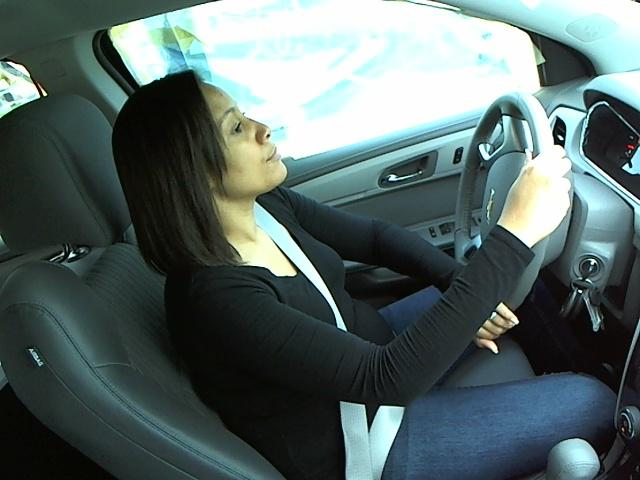

Finished for now!!!


In [42]:
view_image(val_data_dir+'/c0/',os.listdir(val_data_dir+'/c0/'))

## TRAINING

In [ ]:
save_bottleneck_features(location)

In [ ]:
top_model,top_model_history = train_categorical_model(location)

In [ ]:
plot_metrics(top_model_history)

In [ ]:
ft_model,ft_model_history = finetune_categorical_model(location)

In [ ]:
plot_metrics(ft_model_history)

In [47]:
test_labels = []
for i in range(len(val_samples)):
    test_labels += [i]*val_samples[i]
test_labels = np.array(test_labels)
test_labels

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
cm = evaluate_categorical_model(ft_model, val_data_dir, test_labels)

In [48]:
heatmap_labels = ['c0', 'c1', 'c2','c3','c4','c5','c6','c7','c8','c9']

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14},
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

In [32]:
ft_model = load_model(ft_model_path)
ft_model_history = json.load(open('ft_history.json','r'))

Best Model: 
epoch: 3 , val_acc: 0.9861421547247248 , val_loss: 1.4600147535399128


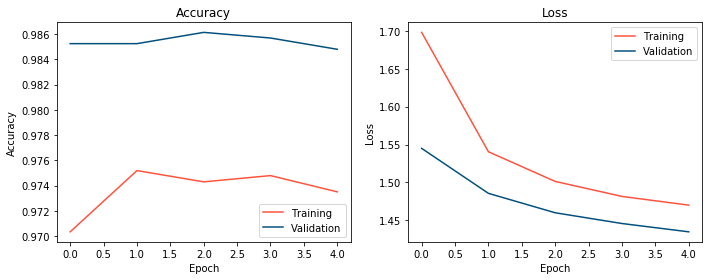

In [33]:
plot_metrics(ft_model_history,5)

In [35]:
with open('ft_model_json.json','w') as f:
    json.dump(ft_model.to_json(),f)
ft_model.save_weights('ft_model_wts.h5')

In [37]:
with open('ft_model_json.json','r') as f:
    ft_model_json = json.load(f)
ft_model = model_from_json(ft_model_json)
ft_model.load_weights('ft_model_wts.h5')

In [43]:
test_dir = '../test_data/'
nb_test_samples = len(os.listdir(test_dir+'test'))
nb_test_samples

79726

In [44]:
def predict_from_test(model,test_dir):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
    test_generator = test_datagen.flow_from_directory(test_dir,
                                     target_size=(256,256),
                                     class_mode=None,
                                     shuffle=False,
                                     batch_size=32)
    predictions = model.predict_generator(test_generator,
                               steps=nb_test_samples/32,
                               verbose=1)
    return predictions

In [45]:
predict_from_test(ft_model,test_dir)

Found 79726 images belonging to 1 classes.


Exception in thread Thread-27:
Traceback (most recent call last):
  File "/home/akash/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/akash/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/akash/anaconda3/lib/python3.6/site-packages/keras/utils/data_utils.py", line 579, in data_generator_task
    generator_output = next(self._generator)
TypeError: 'ImageDataGenerator' object is not an iterator



StopIteration: 